In [1]:
!pip install -q git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q git+https://github.com/albumentations-team/albumentations
!pip install -q torchinfo

In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

import random
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nnd
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

In [3]:
IMAGE_SIZE = 320
BATCH_SIZE = 7
EPOCHS = 25

color_dict = pd.read_csv('../input/deepglobe-land-cover-classification-dataset/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [4]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("../input/deepglobe-land-cover-classification-dataset/train/*.jpg")), 
    'MASKS': sorted(glob("../input/deepglobe-land-cover-classification-dataset/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

IMAGES  \
0  ../input/deepglobe-land-cover-classification-d...   
1  ../input/deepglobe-land-cover-classification-d...   
2  ../input/deepglobe-land-cover-classification-d...   
3  ../input/deepglobe-land-cover-classification-d...   
4  ../input/deepglobe-land-cover-classification-d...   

                                               MASKS  
0  ../input/deepglobe-land-cover-classification-d...  
1  ../input/deepglobe-land-cover-classification-d...  
2  ../input/deepglobe-land-cover-classification-d...  
3  ../input/deepglobe-land-cover-classification-d...  
4  ../input/deepglobe-land-cover-classification-d...

In [5]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.10, random_state=42)
pd_train, pd_val = train_test_split(pd_train, test_size=0.10, random_state=42)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 649
Validation set size: 73
Testing set size: 81


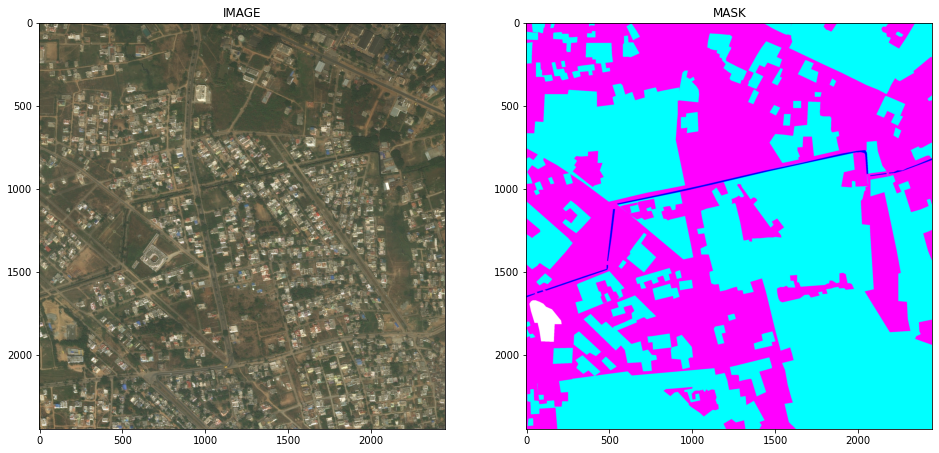

In [6]:
index = 0

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [7]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

In [8]:
import albumentations as aug
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [9]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None, preprocessing=None):
        self.df = df
        self.augmentations = augmentations
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = image[:,:,::-1]
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        # mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = mask[:,:,::-1]
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = data['image'], data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [10]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment, get_preprocessing(preprocessing_fn))
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment, get_preprocessing(preprocessing_fn))
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment, get_preprocessing(preprocessing_fn))

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

In [11]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [12]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([7, 3, 320, 320]), torch.Size([7, 1, 320, 320]))

In [13]:
!wget 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth'

--2022-11-26 18:12:42--  https://download.pytorch.org/models/vgg19_bn-c79401a0.pth
Resolving download.pytorch.org (download.pytorch.org)... 13.227.219.81, 13.227.219.43, 13.227.219.108, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.227.219.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574769405 (548M) [application/octet-stream]
Saving to: ‘vgg19_bn-c79401a0.pth’

vgg19_bn-c79401a0.p 100%[===================>] 548.14M  19.9MB/s    in 25s     

2022-11-26 18:13:08 (21.5 MB/s) - ‘vgg19_bn-c79401a0.pth’ saved [574769405/574769405]



In [14]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score
from torchvision import models

# Model Definition

def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
                
class _DecoderBlock(pl.LightningModule):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)


class SegNet(pl.LightningModule):
    def __init__(self, num_classes=len(CLASSES), pretrained=True):
        super(SegNet, self).__init__()
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
        vgg = models.vgg19_bn()
        vgg19_bn_path = "vgg19_bn-c79401a0.pth"
        if pretrained:
            vgg.load_state_dict(torch.load(vgg19_bn_path))
        vgg = vgg.cuda()
        features = list(vgg.features.children())
        self.enc1 = nn.Sequential(*features[0:7])
        self.enc2 = nn.Sequential(*features[7:14])
        self.enc3 = nn.Sequential(*features[14:27])
        self.enc4 = nn.Sequential(*features[27:40])
        self.enc5 = nn.Sequential(*features[40:])

        self.dec5 = nn.Sequential(
            *([nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)] +
              [nn.Conv2d(512, 512, kernel_size=3, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(inplace=True)] * 4)
        )
        self.dec4 = _DecoderBlock(1024, 256, 4)
        self.dec3 = _DecoderBlock(512, 128, 4)
        self.dec2 = _DecoderBlock(256, 64, 2)
        self.dec1 = _DecoderBlock(128, num_classes, 2)
        initialize_weights(self.dec5, self.dec4, self.dec3, self.dec2, self.dec1)

    def forward(self, x, targets=None):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        dec5 = self.dec5(enc5)
        dec4 = self.dec4(torch.cat([enc4, dec5], 1))
        dec3 = self.dec3(torch.cat([enc3, dec4], 1))
        dec2 = self.dec2(torch.cat([enc2, dec3], 1))
        dec1 = self.dec1(torch.cat([enc1, dec2], 1))
        outputs = nn.Parameter(dec1)
#         print("output: ",outputs.shape)
        if targets is not None:
#             print("Target: ", torch.sum(targets))
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [15]:
from torchinfo import summary

model = SegNet()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
SegNet                                   [7, 7, 320, 320]          --
├─Sequential: 1-1                        [7, 64, 160, 160]         --
│    └─Conv2d: 2-1                       [7, 64, 320, 320]         1,792
│    └─BatchNorm2d: 2-2                  [7, 64, 320, 320]         128
│    └─ReLU: 2-3                         [7, 64, 320, 320]         --
│    └─Conv2d: 2-4                       [7, 64, 320, 320]         36,928
│    └─BatchNorm2d: 2-5                  [7, 64, 320, 320]         128
│    └─ReLU: 2-6                         [7, 64, 320, 320]         --
│    └─MaxPool2d: 2-7                    [7, 64, 160, 160]         --
├─Sequential: 1-2                        [7, 128, 80, 80]          --
│    └─Conv2d: 2-8                       [7, 128, 160, 160]        73,856
│    └─BatchNorm2d: 2-9                  [7, 128, 160, 160]        256
│    └─ReLU: 2-10                        [7, 128, 160, 160]        --
│

In [18]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log-segnet")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

In [19]:
trainer.fit(model, data_module)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
trainer.test(model, data_module)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.7591292858123779     │
│       test/F1score        │    0.1569526344537735     │
│         test/IoU          │    0.08544085174798965    │
│         test/Loss         │    0.6265333890914917     │
│      test/Precision       │    0.1569526344537735     │
│        test/Recall        │    0.1569526344537735     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.6265333890914917,
  'test/IoU': 0.08544085174798965,
  'test/Accuracy': 0.7591292858123779,
  'test/Precision': 0.1569526344537735,
  'test/Recall': 0.1569526344537735,
  'test/F1score': 0.1569526344537735}]

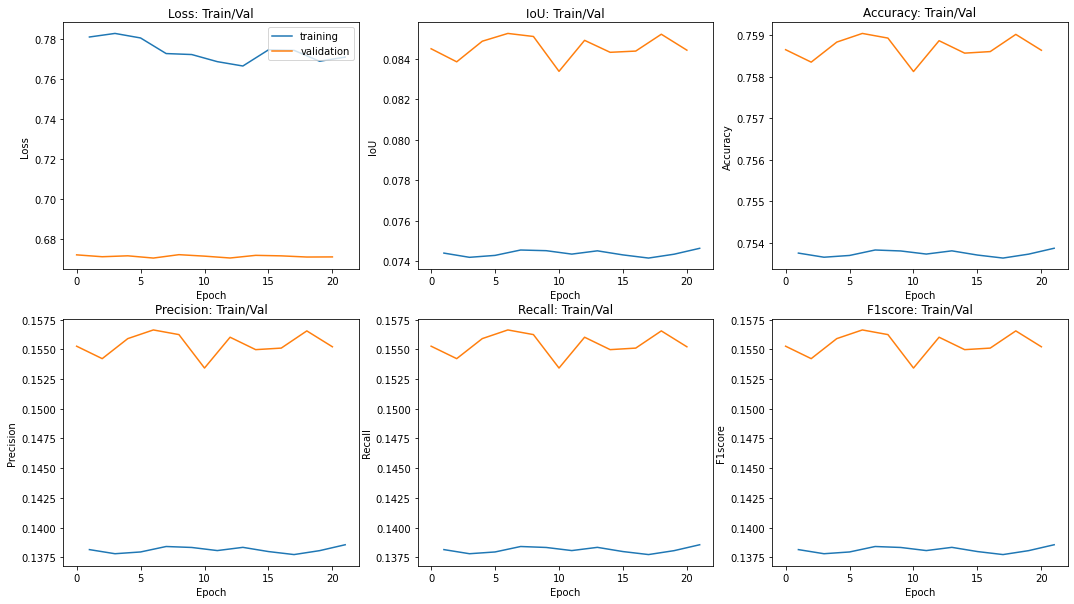

In [22]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log-segnet/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

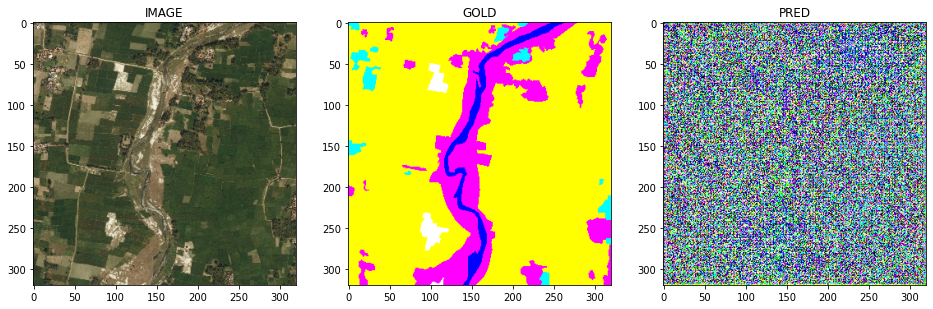

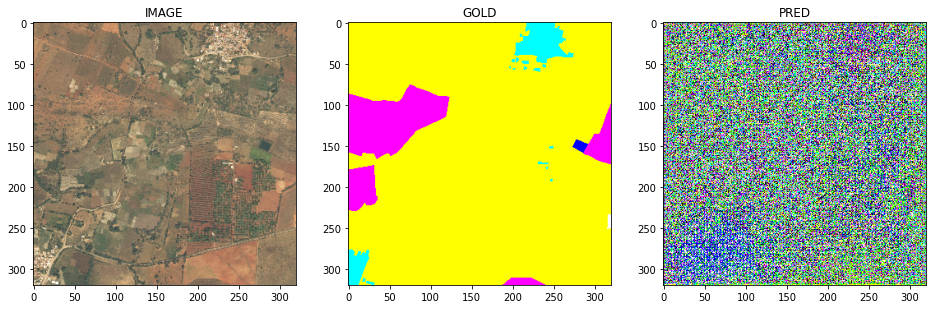

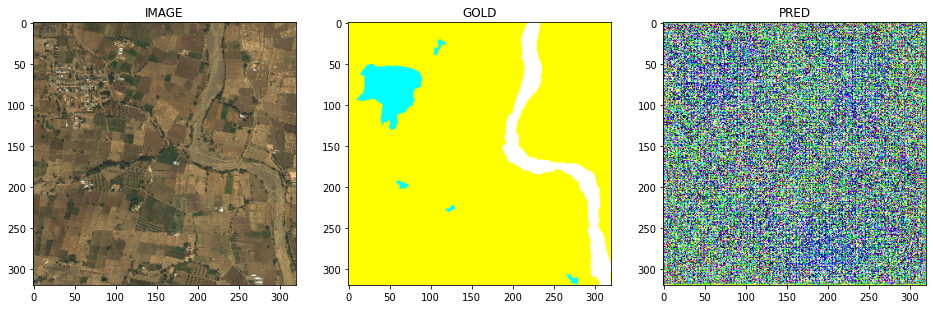

In [23]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()
image, mask = next(iter(data_module.test_dataloader()))
outputs = model(image)
for i in range(BATCH_SIZE//2):
    pred_category = outputs[i].argmax(dim=0).unsqueeze(1).type(torch.int64).squeeze()
    pred_rgb = category2rgb(pred_category.cpu())
    gold_mask = category2rgb(mask[i].squeeze().cpu())
    test_img = image[i].permute(1,2,0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))
    ax1.set_title('IMAGE')
    ax1.imshow(test_img)

    ax2.set_title('GOLD')
    ax2.imshow(gold_mask)

    ax3.set_title('PRED')
    ax3.imshow(pred_rgb)

In [88]:
image, mask = next(iter(data_module.train_dataloader()))
image[0].shape, mask[0].shape

(torch.Size([3, 320, 320]), torch.Size([1, 320, 320]))

torch.Size([320, 320, 3])
Mask:  (320, 320, 3)


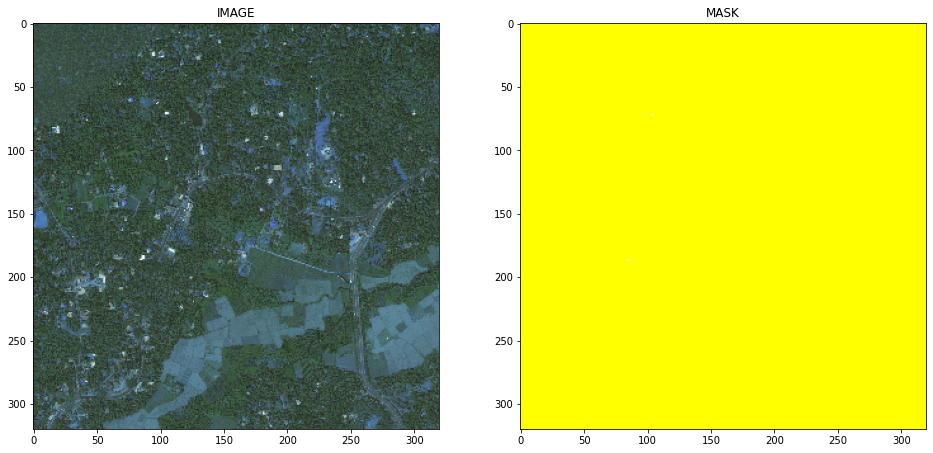

In [94]:
index = 200

sample_img = image[2]
sample_img = sample_img.permute(1, 2, 0)
print(sample_img.shape)
sample_img = cv2.cvtColor(sample_img.numpy(), cv2.COLOR_BGR2RGB)

# sample_msk = cv2.imread(mask[0])
sample_msk = mask[2]
sample_msk = sample_msk.permute(1, 2, 0)
sample_msk = torch.squeeze(sample_msk)
sample_msk = category2rgb(sample_msk)
print("Mask: ", sample_msk.shape)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [71]:
category2rgb(sample_msk)

IndexError: boolean index did not match indexed array along dimension 2; dimension is 3 but corresponding boolean dimension is 1

In [81]:
sample_msk = mask[0]
sample_msk = sample_msk.permute(1, 2, 0)
sample_msk = torch.squeeze(sample_msk)
sample_msk = category2rgb(sample_msk)
sample_msk.shape

(320, 320, 3)

IMg:  (2448, 2448, 3)
Msk:  (2448, 2448, 3)


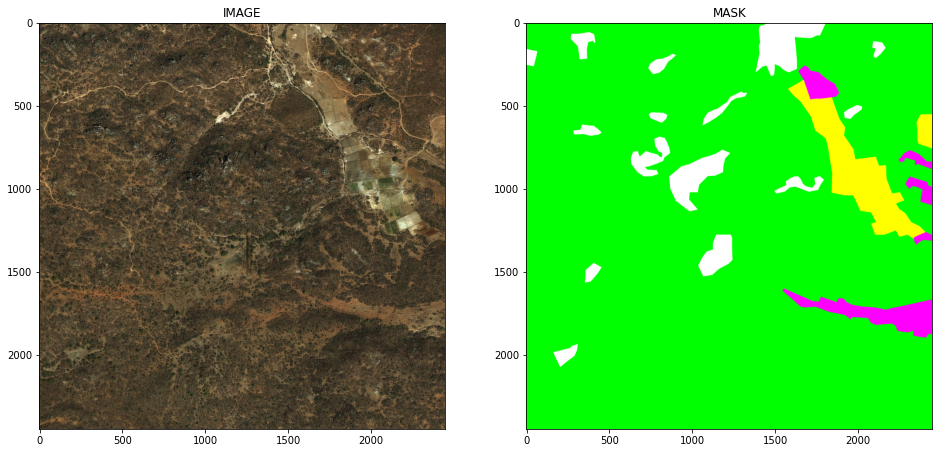

In [96]:
index = 200

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)
print("IMg: ", sample_img.shape)
print("Msk: ", sample_msk.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [97]:
cats = rgb2category(sample_msk)
rgb = category2rgb(cats)


In [98]:
i = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

In [112]:
pd_test.iloc[0]

IMAGES    ../input/deepglobe-land-cover-classification-d...
MASKS     ../input/deepglobe-land-cover-classification-d...
Name: 8, dtype: object

In [115]:
datasette = SegmentationDataset(pd_test.iloc[0:2], test_augment, get_preprocessing(preprocessing_fn))
image, mask = next(iter(datasette))
image.shape, mask.shape

(torch.Size([3, 320, 320]), torch.Size([1, 320, 320]))

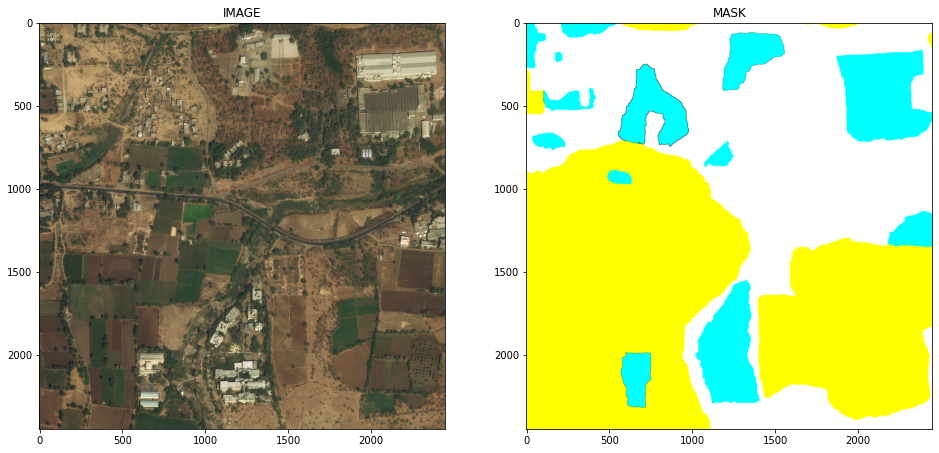

In [116]:
index = 0

sample_img = cv2.imread(pd_test.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_test.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [118]:
image = torch.reshape(image, (1,3,320,320))
output = model(image)
output.shape

torch.Size([1, 7, 320, 320])

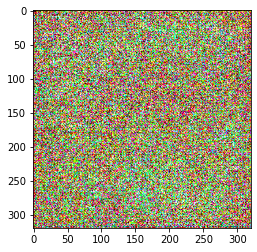

In [127]:
mask = category2rgb(output.argmax(dim=1).unsqueeze(1).type(torch.int64).squeeze())
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
plt.imshow(mask)

[https://github.com/delta-onera/segnet_pytorch/blob/master/segnet.py](http://)

In [33]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class SegNet(pl.LightningModule):
    def __init__(self, num_classes=len(CLASSES), pretrained=True):
        super(SegNet, self).__init__()
        batchNorm_momentum = 0.1
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)

    def forward(self, x, targets=None):
        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p, id1 = F.max_pool2d(x12,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p, id2 = F.max_pool2d(x22,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3p, id3 = F.max_pool2d(x33,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4p, id4 = F.max_pool2d(x43,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5p, id5 = F.max_pool2d(x53,kernel_size=2, stride=2,return_indices=True)


        # Stage 5d
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)

        outputs = x11d
    
        if targets is not None:
#             print("Target: ", torch.sum(targets))
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [34]:
from torchinfo import summary

model = SegNet()
model.load_state_dict(torch.load("vgg19_bn-c79401a0.pth"), strict=False) 
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
SegNet                                   [7, 7, 320, 320]          --
├─Conv2d: 1-1                            [7, 64, 320, 320]         1,792
├─BatchNorm2d: 1-2                       [7, 64, 320, 320]         128
├─Conv2d: 1-3                            [7, 64, 320, 320]         36,928
├─BatchNorm2d: 1-4                       [7, 64, 320, 320]         128
├─Conv2d: 1-5                            [7, 128, 160, 160]        73,856
├─BatchNorm2d: 1-6                       [7, 128, 160, 160]        256
├─Conv2d: 1-7                            [7, 128, 160, 160]        147,584
├─BatchNorm2d: 1-8                       [7, 128, 160, 160]        256
├─Conv2d: 1-9                            [7, 256, 80, 80]          295,168
├─BatchNorm2d: 1-10                      [7, 256, 80, 80]          512
├─Conv2d: 1-11                           [7, 256, 80, 80]          590,080
├─BatchNorm2d: 1-12                      [7, 256, 80, 

In [35]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log-segnet")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

In [36]:
trainer.fit(model, data_module)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [37]:
trainer.test(model, data_module)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.8751521110534668     │
│       test/F1score        │     0.563032329082489     │
│         test/IoU          │    0.47706034779548645    │
│         test/Loss         │       2837581056.0        │
│      test/Precision       │     0.563032329082489     │
│        test/Recall        │     0.563032329082489     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 2837581056.0,
  'test/IoU': 0.47706034779548645,
  'test/Accuracy': 0.8751521110534668,
  'test/Precision': 0.563032329082489,
  'test/Recall': 0.563032329082489,
  'test/F1score': 0.563032329082489}]

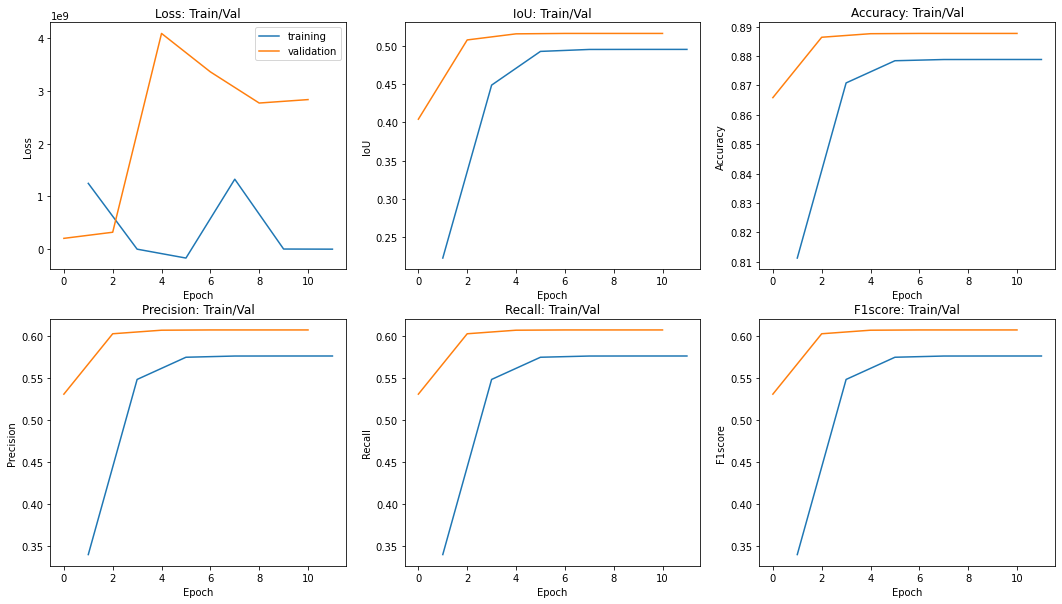

In [38]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log-segnet/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

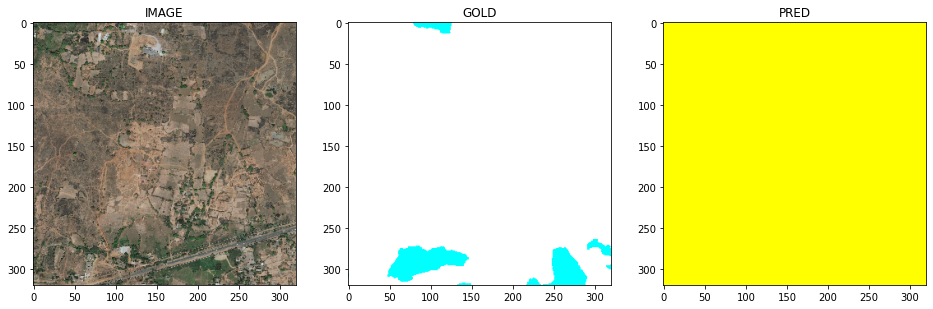

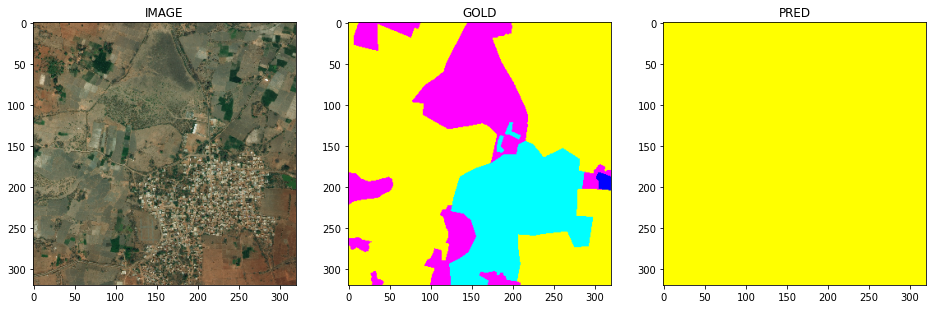

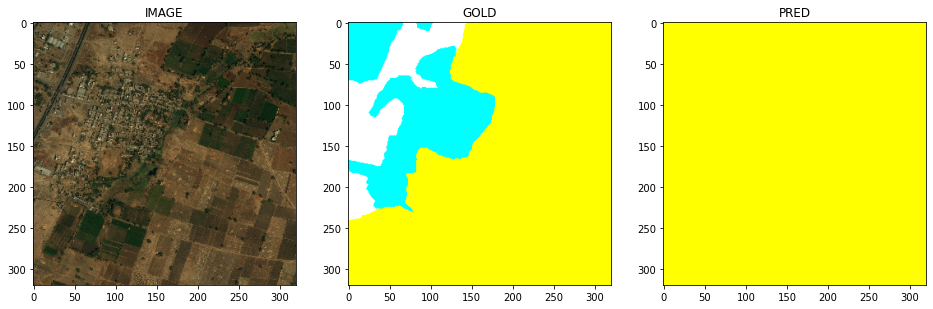

In [40]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test[-50:], batch_size=BATCH_SIZE)
data_module.setup()
image, mask = next(iter(data_module.test_dataloader()))
outputs = model(image)
for i in range(BATCH_SIZE//2):
    pred_category = outputs[i].argmax(dim=0).unsqueeze(1).type(torch.int64).squeeze()
    pred_rgb = category2rgb(pred_category.cpu())
    gold_mask = category2rgb(mask[i].squeeze().cpu())
    test_img = image[i].permute(1,2,0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))
    ax1.set_title('IMAGE')
    ax1.imshow(test_img)

    ax2.set_title('GOLD')
    ax2.imshow(gold_mask)

    ax3.set_title('PRED')
    ax3.imshow(pred_rgb)